# Linear Regression - Ordinary Least Square

In Matrix notration, the matrix $X$ is of dimensions $n \times p$ where is each row is an example and each column is a feature dimension. 

Similarily, $y$ is of dimension $n \times 1$ and $w$ is of dimensions $p \times 1$.

The model is $\hat{y}=X\cdot w$ where we assume for simplicity that $X$'s first columns equals to 1 (one padding), to account for the bias term.

Our objective is to optimize the loss $L$ defines as resiudal sum of squares (RSS): 

$L_{RSS}=\frac{1}{N}\left\Vert Xw-y \right\Vert^2$ (notice that in matrix notation this means summing over all examples, so $L$ is scalar.)

To find the optimal $w$ one needs to derive the loss with respect to $w$.

$\frac{\partial{L_{RSS}}}{\partial{w}}=\frac{2}{N}X^T(Xw-y)$ 

Thus, the gardient descent solution is $w'=w-\eta \frac{2}{N}X^T(Xw-y)$.

Solving $\frac{\partial{L_{RSS}}}{\partial{w}}=0$ for $w$ one can also get analytical solution:

$w_{OLS}=(X^TX)^{-1}X^Ty$

The first term, $(X^TX)^{-1}X^T$ is also called the pseudo inverse of $X$.

In [1]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

plt.style.use("bmh")

In [2]:
class OrdinaryLinearRegression:
    '''
    For an in depth explanation of OLS see introduction to notebook
    '''
    
    def __init__(self, lambd=0):
        self.w = None
        self.lambd = lambd
        
    def fit(self, X, y):
        X = self.norm_cols(X)
        X = np.concatenate([X, np.expand_dims(np.ones(X.shape[0]), axis=-1)], axis=-1)
        self.w = np.linalg.inv(X.T @ X + self.lambd * np.identity(X.shape[-1])) @ X.T @ y
        
    def predict(self, X):
        X = self.norm_cols(X)
        X = np.concatenate([X, np.expand_dims(np.ones(X.shape[0]), axis=-1)], axis=-1)
        return X @ self.w
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return (np.square(y - y_pred)).mean().sum()
    
    @staticmethod
    def norm_cols(arr):
        def normalize(vec):
            if np.std(vec) == 0:
                std = 1
            else: 
                std = np.std(vec)
            return (vec - np.mean(vec)) / std
    
        return np.apply_along_axis(normalize, 0, arr)


class OrdinaryLinearRegressionGradientDescent(OrdinaryLinearRegression):
    '''
    For an in depth explanation of OLS Gradient Descent see introduction to notebook
    '''
    
    def __init__(self, learning_rate, iterations, lambd=0):
        self.w = None
        self.lr = learning_rate
        self.iters = iterations
        self.lambd = lambd
        
    def fit(self, X, y):
        X = self.norm_cols(X)
        X = np.concatenate([X, np.expand_dims(np.ones(X.shape[0]), axis=-1)], axis=-1)
        self.w = np.ones(X.shape[1])
        w_list = []
        for i in range(self.iters):
            w = self.w
            self.w = w - (self.lr / y.shape[0]) * (X.T @ (X @ w - y) + self.lambd * self.w)


In [3]:
def cross_validate_ols(lrgd, cross_validation=1, test_size=0.25):
    tr_mse = []
    te_mse = []
    for i in range(cross_validation):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=i)
        lrgd.fit(X_train, y_train)
        tr_mse.append(lrgd.score(X_train, y_train))
        te_mse.append(lrgd.score(X_test, y_test))

    print(f'Average Train error is: {np.array(tr_mse).mean()}')
    print(f'Average Test error is: {np.array(te_mse).mean()}')

In [4]:
def gradient_error_graph(points, multiple, rate, test_size=0.25):
    tr_mse = []
    te_mse = []
    iter_list = [k*multiple for k in range(1, points)]
    for i in iter_list:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=i)
        lrgd = OrdinaryLinearRegressionGradientDescent(rate, i)
        lrgd.fit(X_train, y_train)
        tr_mse.append(lrgd.score(X_train, y_train))
        te_mse.append(lrgd.score(X_test, y_test))

    plt.figure(figsize=(20,10))
    plt.plot(iter_list, tr_mse)
    plt.plot(iter_list, te_mse)
    plt.legend(['Train', 'Test'])
    plt.xlabel('Iterations')
    plt.ylabel('MSE')
    print(f'Average Train error is: {np.array(tr_mse).mean()}')
    print(f'Average Test error is: {np.array(te_mse).mean()}\n')\
    
    print(f'Final Train error is: {tr_mse[-1]}')
    print(f'Final Test error is: {te_mse[-1]}')

# Predict on Boston Housing dataset

In [5]:
# Get the boston housing dataset.
housing = load_boston()
X = housing['data']
y = housing['target']

In [6]:
# Fit the model.
lr = OrdinaryLinearRegression()
lr.fit(X, y)
lr.score(X, y)

21.894831181729202

In [7]:
# Training error is slightly smaller if we average 20 models with different train test splits
cross_validate_ols(OrdinaryLinearRegression(), cross_validation=20)

Average Train error is: 21.233613289230185
Average Test error is: 26.382403912014137


In [8]:
# Ridge Linear Regression
# Ridge regression is identical to OLS but with a L2 penalty over the weights:
cross_validate_ols(OrdinaryLinearRegression(lambd=10), cross_validation=20)

Average Train error is: 21.686136779376557
Average Test error is: 26.90160713841302


In [9]:
# Linear regression using Gradient Descent
cross_validate_ols(OrdinaryLinearRegressionGradientDescent(learning_rate=0.01, iterations=5000, lambd=10), cross_validation=20)

Average Train error is: 21.68966621145313
Average Test error is: 26.90441676551348


Text(0, 0.5, 'y predict')

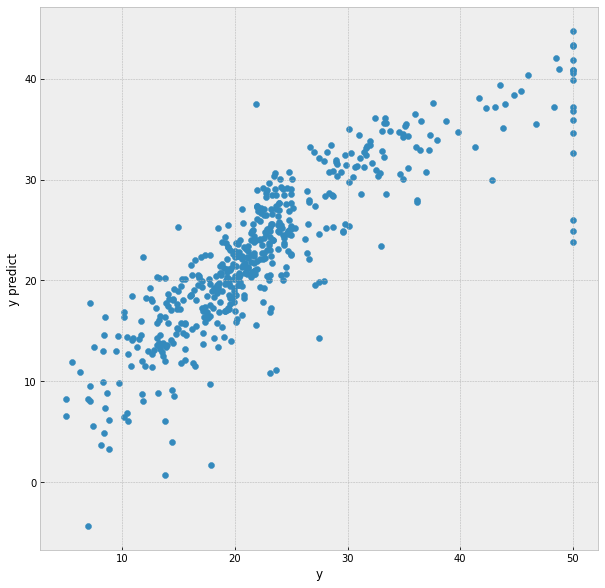

In [10]:
y_pred = lr.predict(X)
plt.figure(figsize=(10,10))
plt.scatter(y, y_pred)
plt.xlabel('y')
plt.ylabel('y predict')

# Learning rate
Below we can see what playing with the learning rate of the model does to error rate. <br>
*Note the size of the MSE per graph is different

#### Rate: 0.001

Average Train error is: 182.23912573525263
Average Test error is: 179.82561545720847

Final Train error is: 56.98923546784408
Final Test error is: 26.40016559265289


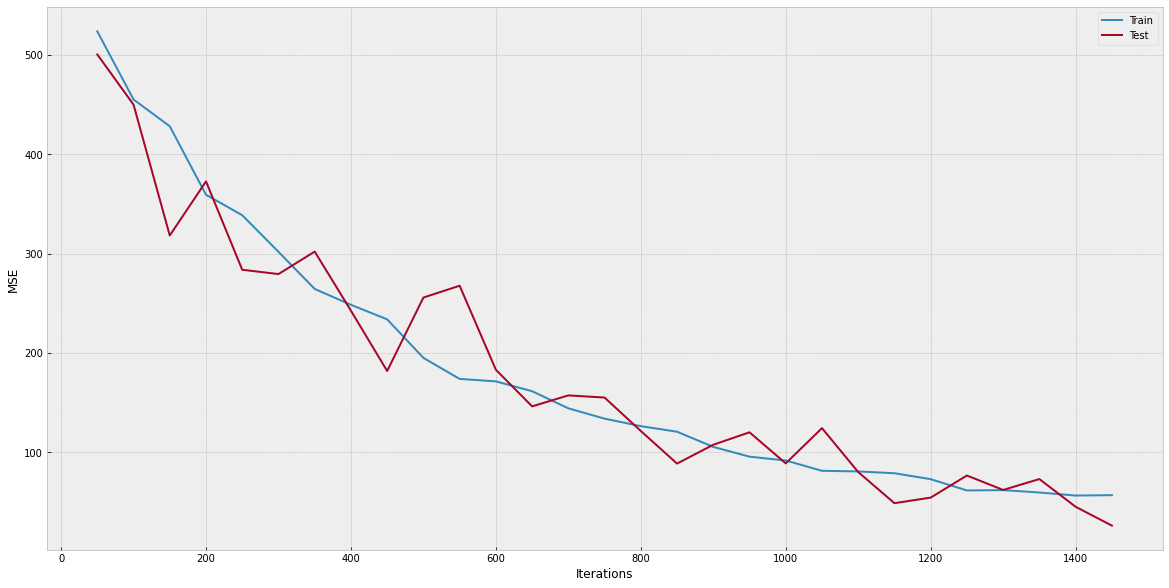

In [11]:
gradient_error_graph(points=30, multiple=50, rate=0.001)

#### Rate: 0.01

Average Train error is: 32.53046581268008
Average Test error is: 34.93046557711372

Final Train error is: 24.56744718045076
Final Test error is: 18.086202880495357


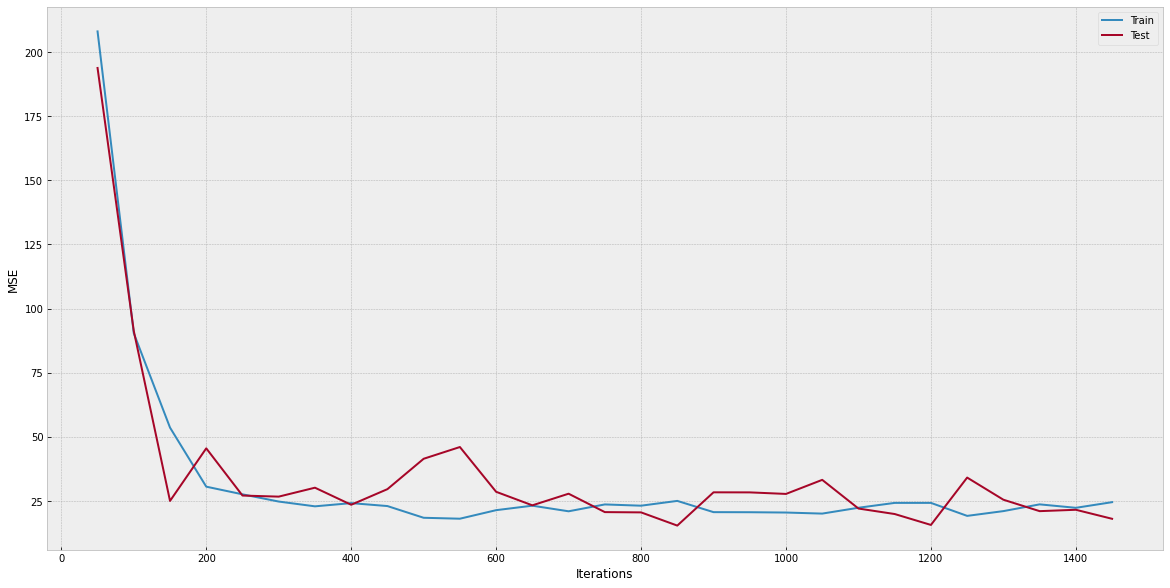

In [12]:
gradient_error_graph(points=30, multiple=50, rate=0.01)

#### Rate: 0.1

Average Train error is: 21.5007110509158
Average Test error is: 25.81998823786384

Final Train error is: 24.4206046703714
Final Test error is: 18.410399132586956


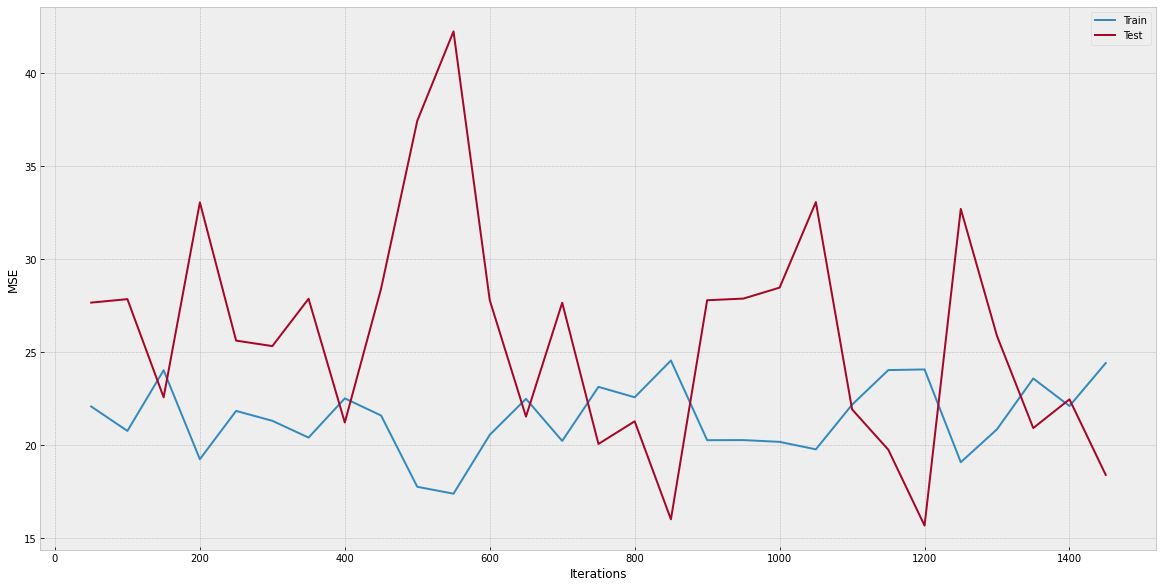

In [13]:
gradient_error_graph(points=30, multiple=50, rate=0.1)